In [3]:
import sys
sys.path.append('./../src')

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker
from sklearn.metrics import mean_squared_error
import pickle
import datetime
import time_series_helpers as tsh
from importlib import reload

%config InlineBackend.figure_format = 'svg'
%matplotlib inline
sns.set_style('white')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.precision', 2)

In [92]:
%load_ext autoreload
%autoreload 2

# EDA

In [5]:
superstore_sales_df = pd.read_csv('../data/train_2.csv')

In [6]:
superstore_sales_df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.62
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.58
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.37


In [7]:
superstore_sales_df[superstore_sales_df['Postal Code'].isna()]

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
2234,2235,CA-2018-104066,05/12/2018,10/12/2018,Standard Class,QJ-19255,Quincy Jones,Corporate,United States,Burlington,Vermont,NaN,East,TEC-AC-10001013,Technology,Accessories,Logitech ClearChat Comfort/USB Headset H390,205.03
5274,5275,CA-2016-162887,07/11/2016,09/11/2016,Second Class,SV-20785,Stewart Visinsky,Consumer,United States,Burlington,Vermont,NaN,East,FUR-CH-10000595,Furniture,Chairs,Safco Contoured Stacking Chairs,715.20
8798,8799,US-2017-150140,06/04/2017,10/04/2017,Standard Class,VM-21685,Valerie Mitchum,Home Office,United States,Burlington,Vermont,NaN,East,TEC-PH-10002555,Technology,Phones,Nortel Meridian M5316 Digital phone,1294.75
9146,9147,US-2017-165505,23/01/2017,27/01/2017,Standard Class,CB-12535,Claudia Bergmann,Corporate,United States,Burlington,Vermont,NaN,East,TEC-AC-10002926,Technology,Accessories,Logitech Wireless Marathon Mouse M705,99.98
9147,9148,US-2017-165505,23/01/2017,27/01/2017,Standard Class,CB-12535,Claudia Bergmann,Corporate,United States,Burlington,Vermont,NaN,East,OFF-AR-10003477,Office Supplies,Art,4009 Highlighters,8.04
9148,9149,US-2017-165505,23/01/2017,27/01/2017,Standard Class,CB-12535,Claudia Bergmann,Corporate,United States,Burlington,Vermont,NaN,East,OFF-ST-10001526,Office Supplies,Storage,Iceberg Mobile Mega Data/Printer Cart,1564.29
9386,9387,US-2018-127292,19/01/2018,23/01/2018,Standard Class,RM-19375,Raymond Messe,Consumer,United States,Burlington,Vermont,NaN,East,OFF-PA-10000157,Office Supplies,Paper,Xerox 191,79.92
9387,9388,US-2018-127292,19/01/2018,23/01/2018,Standard Class,RM-19375,Raymond Messe,Consumer,United States,Burlington,Vermont,NaN,East,OFF-PA-10001970,Office Supplies,Paper,Xerox 1881,12.28
9388,9389,US-2018-127292,19/01/2018,23/01/2018,Standard Class,RM-19375,Raymond Messe,Consumer,United States,Burlington,Vermont,NaN,East,OFF-AP-10000828,Office Supplies,Appliances,Avanti 4.4 Cu. Ft. Refrigerator,542.94
9389,9390,US-2018-127292,19/01/2018,23/01/2018,Standard Class,RM-19375,Raymond Messe,Consumer,United States,Burlington,Vermont,NaN,East,OFF-EN-10001509,Office Supplies,Envelopes,Poly String Tie Envelopes,2.04


In [8]:
# Need to convert Order Date and Ship Date into datetime dtypes (specify exact datetime format for practice)
superstore_sales_df[['Order Date', 'Ship Date']] = superstore_sales_df[['Order Date', 'Ship Date']].apply(pd.to_datetime, errors='coerce', format='%d/%m/%Y')

In [9]:
superstore_sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9800 non-null   int64         
 1   Order ID       9800 non-null   object        
 2   Order Date     9800 non-null   datetime64[ns]
 3   Ship Date      9800 non-null   datetime64[ns]
 4   Ship Mode      9800 non-null   object        
 5   Customer ID    9800 non-null   object        
 6   Customer Name  9800 non-null   object        
 7   Segment        9800 non-null   object        
 8   Country        9800 non-null   object        
 9   City           9800 non-null   object        
 10  State          9800 non-null   object        
 11  Postal Code    9789 non-null   float64       
 12  Region         9800 non-null   object        
 13  Product ID     9800 non-null   object        
 14  Category       9800 non-null   object        
 15  Sub-Category   9800 n

In [10]:
superstore_sales_df['Order Date'].value_counts()

2017-09-05    38
2017-11-10    35
2018-12-02    34
2018-12-01    34
2018-09-02    33
              ..
2015-01-15     1
2017-02-13     1
2017-07-20     1
2017-06-19     1
2015-05-17     1
Name: Order Date, Length: 1230, dtype: int64

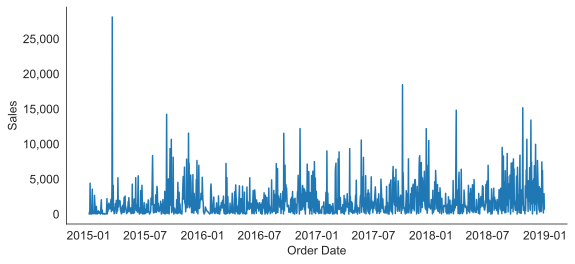

In [12]:
# Plotted without any resampling
fig, ax = plt.subplots(figsize=[9, 4])

sns.lineplot(data=superstore_sales_df, x='Order Date', y='Sales', ci=None, estimator='sum')
ax.yaxis.set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
sns.despine();

In [93]:
superstore_sales_df_monthly_resample = superstore_sales_df.resample('M', on='Order Date') \
                                            .sum()[['Sales']]

superstore_sales_df_monthly_resample

,Sales
Order Date,
2015-01-31,14205.71
2015-02-28,4519.89
2015-03-31,55205.80
2015-04-30,27906.85
2015-05-31,23644.30
2015-06-30,34322.94
2015-07-31,33781.54
2015-08-31,27117.54
2015-09-30,81623.53


In [14]:
superstore_sales_df_monthly_resample.describe()

,Sales
count,48.00
mean,47115.35
std,24978.69
min,4519.89
25%,29621.71
50%,39202.13
75%,64391.97
max,117938.15


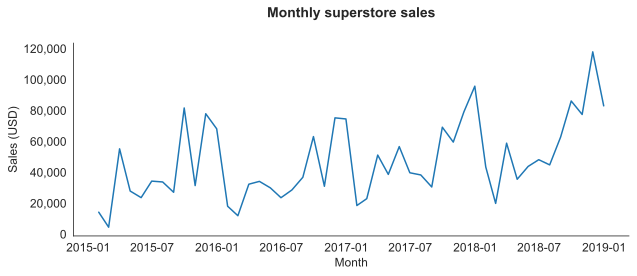

In [124]:
# Plotted with monthly resampling
fig, ax = plt.subplots(figsize=[9, 4])

sns.lineplot(x=superstore_sales_df_monthly_resample.index, 
             y=superstore_sales_df_monthly_resample['Sales'], 
             ci=None)

ax.set_xlabel('Month')
ax.set_ylabel('Sales (USD)')
ax.set_title('Monthly superstore sales', fontweight='bold', fontsize=14, pad=26)
ax.yaxis.set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.tight_layout()
sns.despine()
plt.savefig('/Users/binhhoang/Google Drive/Data Science/@Blog/Blog Images/forecasting-monthly-sales/monthly-superstore-sales', 
            dpi=400);

In [16]:
superstore_sales_df_monthly_resample.index.month

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,
             6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
            11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12],
           dtype='int64', name='Order Date')

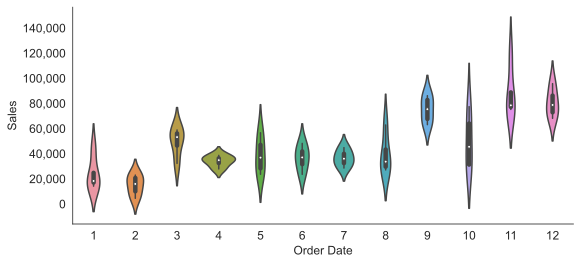

In [17]:
fig, ax = plt.subplots(figsize=[9, 4])

sns.violinplot(x=superstore_sales_df_monthly_resample.index.month,
               y=superstore_sales_df_monthly_resample['Sales'])
ax.yaxis.set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
sns.despine();

# Stationarity Check

In [18]:
superstore_sales_df_monthly_resample[['Sales']].diff()

,Sales
Order Date,
2015-01-31,NaN
2015-02-28,-9685.81
2015-03-31,50685.90
2015-04-30,-27298.94
2015-05-31,-4262.55
2015-06-30,10678.63
2015-07-31,-541.39
2015-08-31,-6664.01
2015-09-30,54505.99


In [19]:
superstore_sales_df_monthly_resample.describe()

,Sales
count,48.00
mean,47115.35
std,24978.69
min,4519.89
25%,29621.71
50%,39202.13
75%,64391.97
max,117938.15


In [20]:
# Check monthly sales standard deviation at various differences

# Lowest std. dev. indicates that no orders of differencing is the most stationary
superstore_sales_df_monthly_resample['Sales'].std() 
superstore_sales_df_monthly_resample['Sales'].diff().std()
superstore_sales_df_monthly_resample['Sales'].diff().diff().std()
superstore_sales_df_monthly_resample['Sales'].diff().diff().diff().std()

24978.68730455254

27304.08199694932

45935.21150504848

81204.54852768495

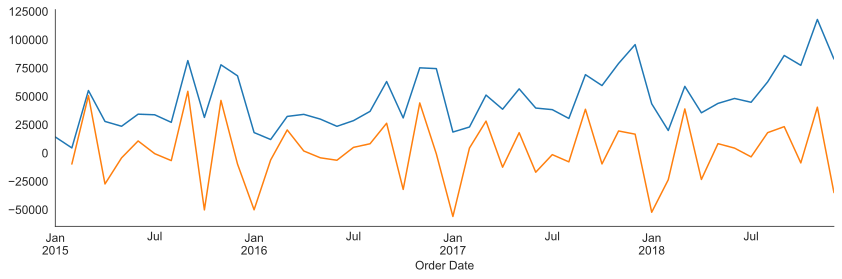

In [21]:
superstore_sales_df_monthly_resample['Sales'].plot()
# One order of differencing yields a higher std. dev., but the
# mean looks more stable over time
superstore_sales_df_monthly_resample['Sales'].diff().plot()
sns.despine();

Test Statistic        -4.42e+00
p-value                2.78e-04
# Lags Used            0.00e+00
# Observations Used    4.70e+01
Critical Value 1%     -3.58e+00
Critical Value 5%     -2.93e+00
Critical Value 10%    -2.60e+00
dtype: float64


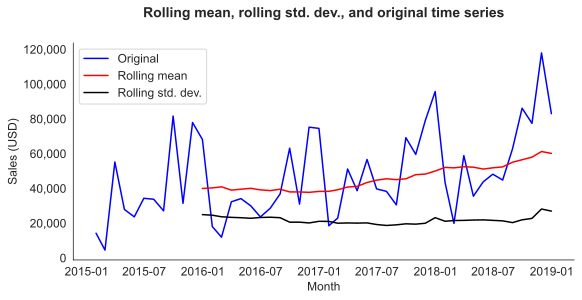

In [127]:
# With a p-value of ~.03%, the Dickey-Fuller test says my time series without any 
# differencing is stationary enough (i.e. we reject the null hypothesis that there
# is a unit root)
tsh.df_test(superstore_sales_df_monthly_resample['Sales'])

Test Statistic        -8.73e+00
p-value                3.27e-14
# Lags Used            1.00e+01
# Observations Used    3.60e+01
Critical Value 1%     -3.63e+00
Critical Value 5%     -2.95e+00
Critical Value 10%    -2.61e+00
dtype: float64


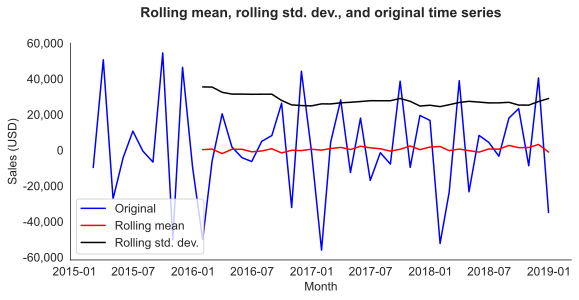

In [128]:
# One order of differencing gives a much lower p-value than no orders of differencing
# in Dickey-Fuller test, but may be unnecessary. 
# Need to use .dropna() since Dickey-Fuller test can't run if there are null values
tsh.df_test(superstore_sales_df_monthly_resample['Sales'].diff().dropna())

# Fitting Model

/Users/binhhoang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


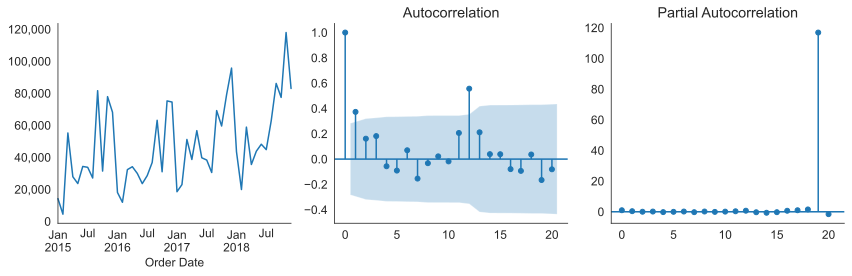

In [28]:
tsh.corr_plots(superstore_sales_df_monthly_resample['Sales'], lags=20)

# Fitting SARIMA Model (0, 0, 0), (0, 1, 1, 12)
Includes constant term (aka intercept), as mean is non-zero

In [29]:
import statsmodels.api as sm

# Fit SARIMA model based on ACF/PACF plots
sarima_model_1 = sm.tsa.statespace.SARIMAX(superstore_sales_df_monthly_resample['Sales'],
                                         order=(0, 0, 0), seasonal_order=(0, 1, 1, 12), 
                                         trend='c', freq='M').fit()
sarima_model_1.summary()

"""
Applied rule 5: In a model with one order of total
differencing, a constant term should be included if the
series has a non-zero average trend.

Applied rule 12: Fit one order of seasonal differencing since
series has a strong and consistent seasonal pattern.

Applied rule 13: Fit one SMA term since autocorrelation at
lag 12 (m=12) is negative.
"""

/Users/binhhoang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                  
==================================================================================
Dep. Variable:                      Sales   No. Observations:                   48
Model:             SARIMAX(0, 1, [1], 12)   Log Likelihood                -389.953
Date:                    Tue, 22 Dec 2020   AIC                            785.907
Time:                            18:35:28   BIC                            790.657
Sample:                        01-31-2015   HQIC                           787.565
                             - 12-31-2018                                         
Covariance Type:                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   6727.6615   2487.898      2.704      0.007    1851.471    1.16e+04
ma.S.L12      -0.2611      0.158     -1.656      0.098      -0.570       0.048
sigma2      1.914e+08      0.062    3.1e+09      0.000    1.91e+08    1.91e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 1.11
Prob(Q):                              0.83   Prob(JB):                         0.57
Heteroskedasticity (H):               3.16   Skew:                             0.39
Prob(H) (two-sided):                  0.06   Kurtosis:                         2.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.64e+25. Standard errors may be unstable.
"""

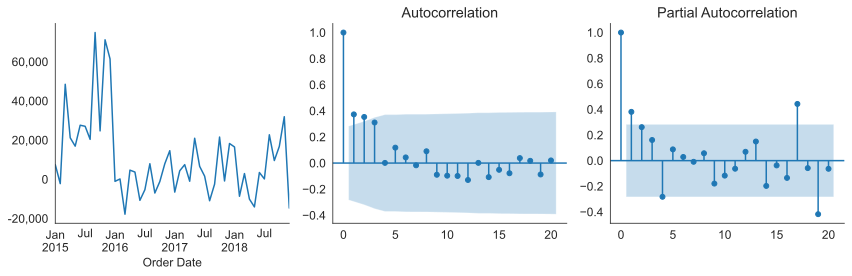

In [35]:
# Plot residuals to analyze what remains for the model to capture
tsh.corr_plots(sarima_model_1.resid, lags=20)

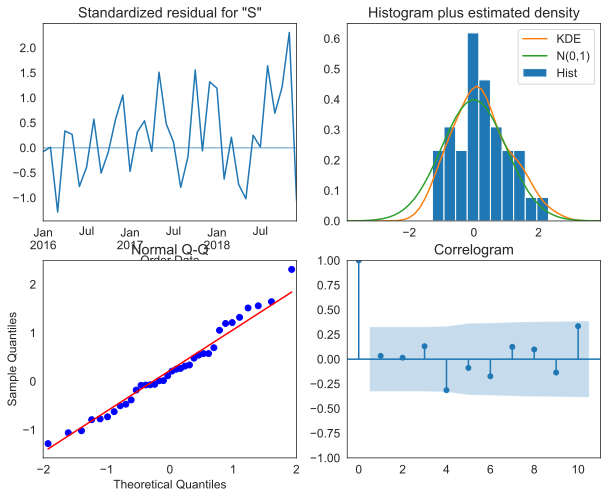

In [31]:
sarima_model_1.plot_diagnostics(figsize=(10, 8));

In [32]:
# These are one-step-ahead predictions (i.e. use the true values of the endogenous
# values at each step to predict the next in-sample value) 
sales_pred = sarima_model_1.predict()

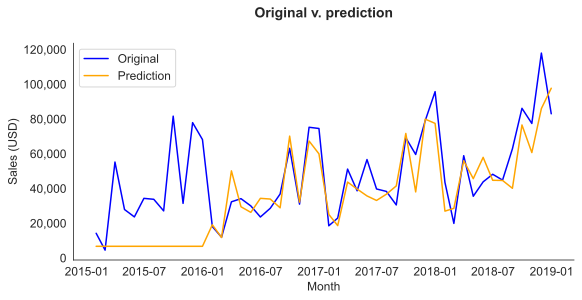

In [136]:
tsh.plot_pred(superstore_sales_df_monthly_resample, sales_pred)

In [95]:
# Run statistical tests to check error terms are i.i.d. and homoskedastic
tsh.residual_tests(sarima_model_1)

Jarque-Bera normality test:         val=1.11 p=0.57
Ljung-Box serial corr. test:        val=7.44 p=0.38
Heteroskedasticity test:            val=3.16 p=0.06


# Fitting SARIMA Model (0, 1, 1), (0, 1, 1, 12)
No constant term (aka intercept), which means mean is zero

In [79]:
# Fit SARIMA model based on ACF/PACF plots
sarima_model_2 = sm.tsa.statespace.SARIMAX(superstore_sales_df_monthly_resample['Sales'],
                                         order=(0, 1, 1), seasonal_order=(0, 1, 1, 12), 
                                         trend='n', freq='M').fit()
sarima_model_2.summary()

"""
Applied rule 5: A model with two orders of total
differencing normally does not include a constant term.

Applied rule 7: Fit one MA term since autocorrelation
at lag 1 is negative and autocorrelations past lag 1
are not statistically significant.

Applied rule 12: Fit one order of seasonal differencing since
series has a strong and consistent seasonal pattern.

Applied rule 13: Fit one SMA term since autocorrelation at
lag 12 (m=12) is negative.
"""

/Users/binhhoang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                   48
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -385.010
Date:                            Tue, 22 Dec 2020   AIC                            776.019
Time:                                    18:43:56   BIC                            780.685
Sample:                                01-31-2015   HQIC                           777.630
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3903      0.141     -2.767      0.006      -0.667      -0.114
ma.S.L12      -0.4364      0.150     -2.914      0.004      -0.730      -0.143
sigma2      2.496e+08    8.4e-11   2.97e+18      0.000     2.5e+08     2.5e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.72   Jarque-Bera (JB):                 1.01
Prob(Q):                              0.40   Prob(JB):                         0.60
Heteroskedasticity (H):               1.33   Skew:                            -0.39
Prob(H) (two-sided):                  0.63   Kurtosis:                         2.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.08e+33. Standard errors may be unstable.
"""

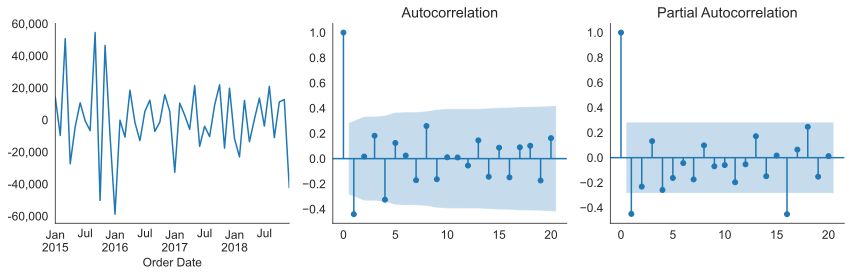

In [78]:
# Plot residuals to analyze what remains for the model to capture
tsh.corr_plots(sarima_model_2.resid, lags=20)

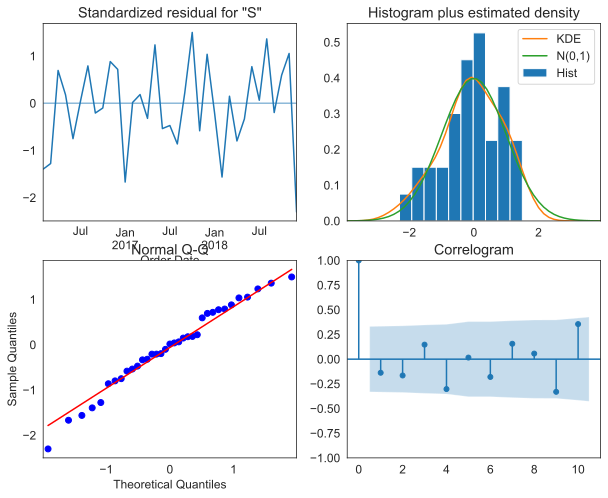

In [63]:
sarima_model_2.plot_diagnostics(figsize=(10, 8));

In [64]:
# These are one-step-ahead predictions (i.e. use the true values of the endogenous
# values at each step to predict the next in-sample value) 
sales_pred_2 = sarima_model_2.predict()

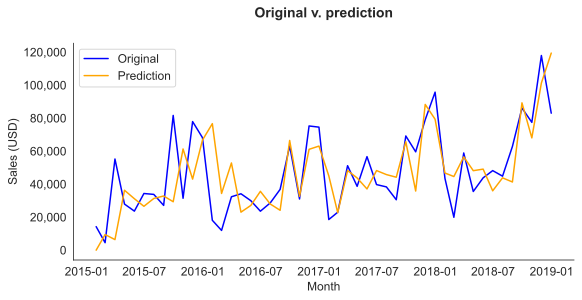

In [135]:
tsh.plot_pred(superstore_sales_df_monthly_resample, sales_pred_2)

In [96]:
tsh.residual_tests(sarima_model_2)

Jarque-Bera normality test:         val=1.01 p=0.60
Ljung-Box serial corr. test:        val=9.10 p=0.25
Heteroskedasticity test:            val=1.33 p=0.63


# Simple validation of sarima_model and sarima_model_2

Note: because my dataset is too small, cross validation doesn't work. Used. simple validation instead. 

Will manually split train/val/test per below: 
* 50% (24 data points)
* 25% (12 data points)
* 25% (12 data points)

In [57]:
# In this case, my X and y are the same because I'm only using endogenous variables,
# but if I were using exogenous variables as well, my X would include the exogenous
# variables, but my y would not as it only needs to include the target
X_train, X_val, X_train_val, X_test = superstore_sales_df_monthly_resample[:24], \
    superstore_sales_df_monthly_resample[24:36], \
    superstore_sales_df_monthly_resample[:36], \
    superstore_sales_df_monthly_resample[36:]

y_train, y_val, y_train_val, y_test = superstore_sales_df_monthly_resample[:24], \
    superstore_sales_df_monthly_resample[24:36], \
    superstore_sales_df_monthly_resample[:36], \
    superstore_sales_df_monthly_resample[36:]

In [84]:
sarima_model_1_train = sm.tsa.statespace.SARIMAX(X_train['Sales'],
                                                 order=(0, 0, 0), seasonal_order=(0, 1, 1, 12),
                                                 trend='c', freq='M').fit()

"""
Applied rule 5: In a model with one order of total
differencing, a constant term should be included if the
series has a non-zero average trend.

Applied rule 12: Fit one order of seasonal differencing since
series has a strong and consistent seasonal pattern.

Applied rule 13: Fit one SMA term since autocorrelation at
lag 12 (m=12) is negative.
"""

sarima_model_2_train = sm.tsa.statespace.SARIMAX(X_train['Sales'],
                                                 order=(0, 1, 1), seasonal_order=(0, 1, 1, 12),
                                                 trend='n', freq='M').fit()

"""
Applied rule 5: A model with two orders of total
differencing normally does not include a constant term.

Applied rule 7: Fit one MA term since autocorrelation
at lag 1 is negative and autocorrelations past lag 1
are not statistically significant.

Applied rule 12: Fit one order of seasonal differencing since
series has a strong and consistent seasonal pattern.

Applied rule 13: Fit one SMA term since autocorrelation at
lag 12 (m=12) is negative.
"""

/Users/binhhoang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)
/Users/binhhoang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [59]:
sarima_model_1_train.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                  
==================================================================================
Dep. Variable:                      Sales   No. Observations:                   24
Model:             SARIMAX(0, 1, [1], 12)   Log Likelihood                -127.414
Date:                    Tue, 22 Dec 2020   AIC                            260.827
Time:                            18:39:30   BIC                            262.282
Sample:                        01-31-2015   HQIC                           260.289
                             - 12-31-2016                                         
Covariance Type:                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -1701.6835   6521.677     -0.261      0.794   -1.45e+04    1.11e+04
ma.S.L12      -0.0588      0.135     -0.437      0.662      -0.323       0.205
sigma2      1.052e+08      0.008   1.31e+10      0.000    1.05e+08    1.05e+08
===================================================================================
Ljung-Box (L1) (Q):                   2.37   Jarque-Bera (JB):                 1.57
Prob(Q):                              0.12   Prob(JB):                         0.46
Heteroskedasticity (H):               0.58   Skew:                            -0.85
Prob(H) (two-sided):                  0.61   Kurtosis:                         2.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.5e+27. Standard errors may be unstable.
"""

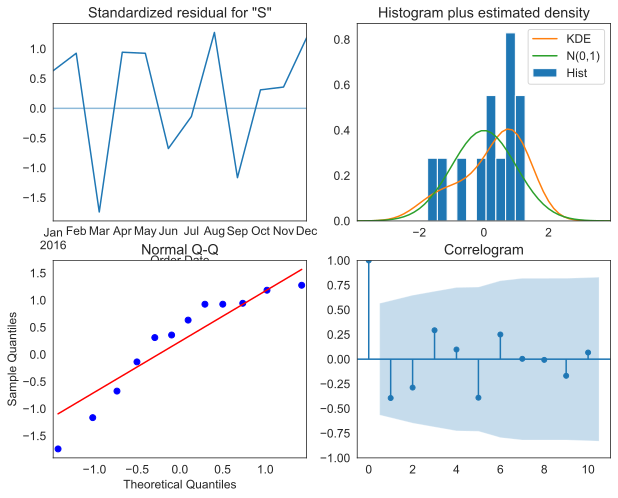

In [97]:
sarima_model_1_train.plot_diagnostics(figsize=(10, 8));

In [98]:
tsh.residual_tests(sarima_model_1_train)

Jarque-Bera normality test:         val=1.57 p=0.46
Ljung-Box serial corr. test:        val=3.76 p=0.15
Heteroskedasticity test:            val=0.58 p=0.61


/Users/binhhoang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/mlemodel.py:3225: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5) for non-seasonal time series and min (2*m, nobs//5) for seasonal time series. Directly set lags to silence this warning.
  FutureWarning


In [60]:
sarima_model_2_train.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                   24
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -116.590
Date:                            Tue, 22 Dec 2020   AIC                            239.179
Time:                                    18:39:33   BIC                            240.373
Sample:                                01-31-2015   HQIC                           238.427
                                     - 12-31-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.9123      0.069     13.305      0.000       0.778       1.047
ma.S.L12      -1.0000      0.749     -1.335      0.182      -2.468       0.468
sigma2      6.507e+07   1.15e-08   5.65e+15      0.000    6.51e+07    6.51e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.67   Jarque-Bera (JB):                 0.56
Prob(Q):                              0.41   Prob(JB):                         0.76
Heteroskedasticity (H):               0.82   Skew:                            -0.26
Prob(H) (two-sided):                  0.85   Kurtosis:                         2.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.25e+31. Standard errors may be unstable.
"""

In [99]:
sarima_model_2_train.plot_diagnostics(figsize=(10, 8));

ValueError: Length of endogenous variable must be larger the the number of lags used in the model and the number of observations burned in the log-likelihood calculation.

<Figure size 1000x800 with 0 Axes>

In [100]:
tsh.residual_tests(sarima_model_2_train)

Jarque-Bera normality test:         val=0.56 p=0.76
Ljung-Box serial corr. test:        val=4.06 p=0.13
Heteroskedasticity test:            val=0.82 p=0.85


In [101]:
sarima_model_1_train_val = sm.tsa.statespace.SARIMAX(X_train_val['Sales'],
                                                   order=(0, 0, 0), seasonal_order=(0, 1, 1, 12),
                                                   trend='c', freq='M').fit()

sarima_model_2_train_val = sm.tsa.statespace.SARIMAX(X_train_val['Sales'],
                                                 order=(0, 1, 1), seasonal_order=(0, 1, 1, 12),
                                                 trend='n', freq='M').fit()

/Users/binhhoang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


In [ ]:
sarima_model_1.predict()

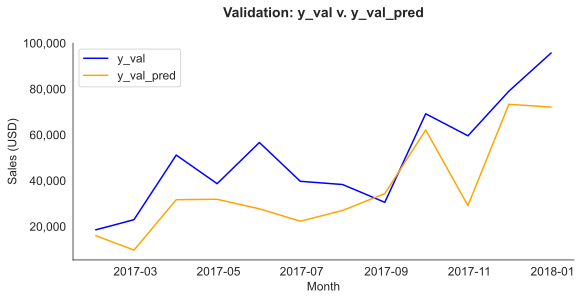

Val RMSE: 16984.06


In [132]:
tsh.simple_validation(sarima_model_1_train, X_train, y_val)

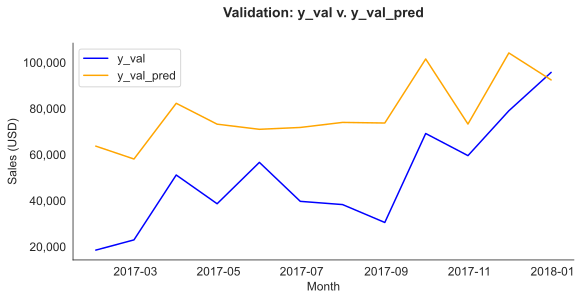

Val RMSE: 31218.05


In [133]:
tsh.simple_validation(sarima_model_2_train, X_train, y_val)

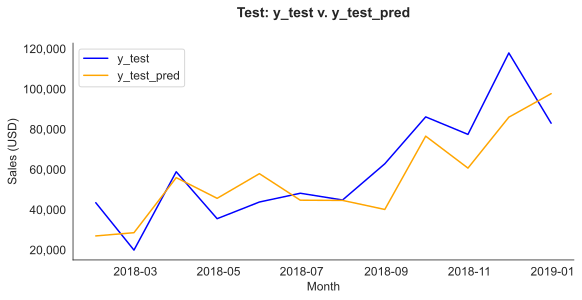

Test RMSE: 15252.72


In [134]:
tsh.test_model(sarima_model_1, X_train_val, y_test)

In [91]:
y_test.std()

Sales    26957.07
dtype: float64

# Scraps

In [ ]:
# from sklearn.model_selection import TimeSeriesSplit

# tscv = TimeSeriesSplit(n_splits=2) # tsv stands for time series validation

# # First split gives me my first train/val set (1/3 train, 1/3 val)
# # Second split gives me my second train/val set (2/3 train, 1/3 val)
# # The denominator of the fraction used for the splits is (n_splits + 1),
# # so 2 splits means I'm using 3rds of my data to generate the splits

# # Below is my cross-validation loop
# for train_index, val_index in tscv.split(y):
#     print("Train:", train_index, "Val:", val_index)
#     X_train, X_val = X.iloc[train_index].set_index('Order Date'), X.iloc[val_index].set_index('Order Date')
#     y_train, y_val = y.iloc[train_index].set_index('Order Date'), y.iloc[val_index].set_index('Order Date')

#     sarima_model = sm.tsa.statespace.SARIMAX(X_train['Sales'],
#                                              order=(0, 0, 0), seasonal_order=(0, 1, 1, 12),
#                                              trend='c', freq='M').fit()
    
#     plot_pred(y_train, sarima_model.predict(start=0, end=23, dynamic=12))

    